In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,text
from scipy import stats
import plotly.express as px
import toml
import psrc_theme
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))
summary_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'summary_configuration.toml'))

# create connection
conn = create_engine('sqlite:///../../../../inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by mode

In [2]:
# Process 2024 observed data
df_obs = pd.read_sql(text("SELECT * FROM observed_transit_boardings"), con=conn.connect())

df_obs["route_id"] = df_obs["route_id"].astype("int")

df_obs = df_obs[df_obs['year'].isin([2023,2024])]

df_obs = pd.pivot_table(df_obs, index='route_id', values='observed_daily', columns='year', aggfunc='sum')
df_obs = df_obs.reset_index()



In [3]:

# Load model results and calculate modeled daily boarding by line
df_transit_line = pd.read_csv(r"..\..\..\..\outputs\transit\transit_line_results.csv")
df_model = df_transit_line.copy()
df_model_daily = (
    df_model.groupby(["route_code", "mode",'agency_code'])
    .agg({"description": "first", "boardings": "sum"})
    .reset_index()
)

# Merge modeled with observed boarding data
df_model_daily["route_code"] = df_model_daily["route_code"].astype("int")
df = df_model_daily.merge(
    df_obs, left_on="route_code", right_on="route_id", how="left"
)
# df.rename(
#     columns={
#         "boardings": "model_boardings",
#         "observed_daily": "observed_boardings",
#     },
#     inplace=True,
# )
# df["diff"] = df["model_boardings"] - df["observed_boardings"]
# df["perc_diff"] = df["diff"] / df["observed_boardings"]
# df[["model_boardings", "observed_boardings"]] = df[
#     ["model_boardings", "observed_boardings"]
# ].fillna(-1)

df.rename(
    columns={
        "boardings": "Model",
        2023: "2023 Spring Observed",
        2024: "2024 Spring Observed",
    },
    inplace=True,
)


df['agency'] = df['agency_code'].astype('int').astype('str').map(summary_config['agency_lookup'])
df_line_boardings_23_24 = df.copy()

In [4]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_mode.csv')).sort_values('observed_boardings', ascending=False)
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df['observed_boardings'].sum(axis=0)
table_df.loc['Total','model_boardings'] = table_df['model_boardings'].sum(axis=0)
table_df.loc['Total','mode'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

index   mode  observed_boardings  model_boardings      diff perc_diff
0      0      b          332,481.24       358,622.77 26,141.53     7.86%
1      4      r           80,839.00        81,496.34    657.34     0.81%
2      2      f            9,907.00         8,830.64 -1,076.36   -10.86%
3      1      c            6,354.00         6,712.24    358.24     5.64%
4      3      p            2,950.00         2,621.70   -328.30   -11.13%
5  Total  Total          432,531.24       458,283.68 25,752.45     5.95%

In [5]:
df_boarding_line = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='description')
df_boarding_line[['observed_boardings','model_boardings']] = df_boarding_line[['observed_boardings','model_boardings']].astype('float')

df_mode = df_boarding_line[df_boarding_line['route_code'].isin([6996,6999,6998])].reset_index()

df_mode['submode'] = df_mode['mode'].map({"r": "Link Red Line", "c": "Sounder"})
df_mode = df_mode[['submode','model_boardings']].copy()
df_mode = df_mode.groupby('submode')['model_boardings'].sum().reset_index()

df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())
df_obs_mode = df_obs.copy()
df_obs_mode['boardings'] = df_obs_mode['boardings'].astype(float)
df_obs_mode = df_obs_mode[df_obs_mode['submode'].isin(["Link","Sounder"])].copy()
df_obs_mode['submode'] = df_obs_mode['submode'].map({"Link": "Link Red Line", "Sounder": "Sounder"})

df_obs_mode = df_obs_mode.groupby(['submode','year'])['boardings'].sum().unstack().reset_index()
df_obs_mode = df_obs_mode.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_mode = df_obs_mode.merge(df_mode, on='submode')

df_mode['2023 % diff'] = (df_mode['model_boardings']-df_mode['2023 boarding'])/df_mode['2023 boarding']
df_mode['2024 % diff'] = (df_mode['model_boardings']-df_mode['2024 boarding'])/df_mode['2024 boarding']
df_mode[['2023 % diff']] = df_mode[['2023 % diff']].applymap(format_percent)
df_mode[['2024 % diff']] = df_mode[['2024 % diff']].applymap(format_percent)

df_mode

submode  2023 boarding  2024 boarding  model_boardings 2023 % diff  \
0  Link Red Line      78,765.00      91,203.00        77,916.99      -1.08%   
1        Sounder       6,765.00       7,711.00         6,712.24      -0.78%   

  2024 % diff  
0     -14.57%  
1     -12.95%

### boarding by agency

In [6]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [7]:
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
table_df.loc['Total','agency'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

index              agency  observed_boardings  model_boardings      diff  \
0      2   King County Metro          254,568.00       268,145.07 13,577.07   
1      5       Sound Transit          115,114.00       128,218.75 13,104.75   
2      0   Community Transit           21,752.24        27,420.69  5,668.45   
3      4      Pierce Transit           21,185.00        13,870.34 -7,314.66   
4      6  Washington Ferries            7,883.00         5,348.55 -2,534.45   
5      3      Kitsap Transit            7,829.00        10,711.57  2,882.57   
6      1     Everett Transit            4,201.00         4,549.01    348.01   
7  Total               Total          432,532.24       458,263.99 25,731.75   

  perc_diff  
0     5.33%  
1    11.38%  
2    26.06%  
3   -34.53%  
4   -32.15%  
5    36.82%  
6     8.28%  
7     5.95%

In [8]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv'), usecols=['agency', 'model_boardings']).sort_values('model_boardings', ascending=False)
df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())

df_obs_agency = df_obs.copy()
df_obs_agency['boardings'] = df_obs_agency['boardings'].astype(float)
df_obs_agency = df_obs_agency.groupby(['agency','year'])['boardings'].sum().unstack().reset_index()
df_obs_agency = df_obs_agency.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_agency = df_obs_agency.merge(df, on='agency')

df_agency['2023 % diff'] = (df_agency['model_boardings']-df_agency['2023 boarding'])/df_agency['2023 boarding']
df_agency['2024 % diff'] = (df_agency['model_boardings']-df_agency['2024 boarding'])/df_agency['2024 boarding']
df_agency[['2023 % diff']] = df_agency[['2023 % diff']].applymap(format_percent)
df_agency[['2024 % diff']] = df_agency[['2024 % diff']].applymap(format_percent)
df_agency = df_agency.replace('inf%', '-')

df_agency

agency  2023 boarding  2024 boarding  model_boardings  \
0   Community Transit      23,000.00           0.00        27,420.69   
1     Everett Transit           0.00           0.00         4,549.01   
2   King County Metro     244,306.00     272,556.00       268,145.07   
3      Kitsap Transit       8,000.00       9,300.00        10,711.57   
4      Pierce Transit      19,974.00           0.00        13,870.34   
5       Sound Transit     115,516.00     133,703.00       128,218.75   
6  Washington Ferries           0.00           0.00         5,348.55   

  2023 % diff 2024 % diff  
0      19.22%           -  
1           -           -  
2       9.76%      -1.62%  
3      33.89%      15.18%  
4     -30.56%           -  
5      11.00%      -4.10%  
6           -           -

In [9]:
# df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv')).sort_values('observed_boardings', ascending=False)
df = df_line_boardings_23_24.copy()
df
df = df[df['mode'].isin(['b'])]
df = df.groupby(['agency']).sum()[['Model','2023 Spring Observed','2024 Spring Observed']]
df


Model  2023 Spring Observed  2024 Spring Observed
agency                                                                  
Community Transit  27,420.69             21,752.24                  0.00
Everett Transit     4,549.01              4,201.00              5,862.00
King County Metro 265,769.00            252,852.00            262,018.00
Kitsap Transit      5,321.54              4,048.00                  0.00
Pierce Transit     13,870.34             21,185.00             21,911.00
Sound Transit      41,692.19             28,444.00             31,292.00

### boarding by key route

In [10]:

df = df_line_boardings_23_24[df_line_boardings_23_24['mode'].isin(['f','p'])][['route_code','description','agency','Model','2023 Spring Observed','2024 Spring Observed']]
df = df[df['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)
df_table = df.copy()
# df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('Model', ascending=False)

index           description    Model  2023 Spring Observed  \
6     278  WSF Seattle-Bain Isl 3,768.61              4,981.00   
2     270  Seattle-Bremerton FF 3,564.46              1,913.00   
3     271    Brem-Pt Orchard FF   982.77                768.00   
4     273  Seattle-Southwrth FF   637.33                631.00   
9     281  WSF Fauntleroy-Vashn   610.04                659.00   
0     147  973 W Sea Water Taxi   396.78                837.00   
8     280  WSF Fauntleroy-Swrth   347.22                134.00   
1     148  975 Vashn Water Taxi   316.97                356.00   
11    283  WSF Pt Def-Tahlequah   194.73                267.00   
5     277  WSF Edmonds-Kingston   180.17              1,020.00   
7     279      WSF Seattle-Brem   168.37                739.00   
10    282  WSF Vashon-Southwrth    79.42                 83.00   

    2024 Spring Observed  
6               5,404.00  
2               2,068.00  
3                 857.00  
4                 749.00  
9                 661.00  
0                 873.00  
8                 184.00  
1                 390.00  
11                325.00  
5               1,068.00  
7                 877.00  
10                 95.00

In [11]:
# if len(df) > 0:
#     ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
#     lim = df[['observed_boardings','model_boardings']].max().max()*1.05
#     ax.set_ylim(0,lim)
#     ax.set_xlim(0,lim)
#     x = np.linspace(*ax.get_xlim())
#     ax.plot(x, x)
#     slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
#     print('r^2 ' + str('') + ': ' + str(r_value))

In [12]:
df = df_line_boardings_23_24[df_line_boardings_23_24['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
# df.drop(['route_code','agency'], axis=1, inplace=True)
df_table = df[['route_code','description','agency','Model','2023 Spring Observed','2024 Spring Observed']].copy()
# df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

route_code    description         agency     Model  2023 Spring Observed  \
0        6996  Link Red Line  Sound Transit 77,916.99             78,772.00   
1        6998  Sounder South  Sound Transit  6,708.04              6,038.00   
2        6999  Sounder North  Sound Transit      4.20                316.00   

   2024 Spring Observed  
0             91,213.00  
1              7,168.00  
2                367.00

In [13]:
# if len(df) > 0:
#     ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
#     lim = df[['observed_boardings','model_boardings']].max().max()*1.05
#     ax.set_ylim(0,lim)
#     ax.set_xlim(0,lim)
#     x = np.linspace(*ax.get_xlim())
#     ax.plot(x, x)
#     slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
#     print('r^2 ' + str('') + ': ' + str(r_value))

In [14]:
# df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
# df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
#                                             1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
#                                             1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
#                                             6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
#                                             1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
# df.drop(['route_code','agency'], axis=1, inplace=True)

df = df_line_boardings_23_24[df_line_boardings_23_24['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
# df.drop(['route_code','agency'], axis=1, inplace=True)
df_table = df[['route_code','description','agency','Model','2023 Spring Observed','2024 Spring Observed']].copy()

df_table = df[['route_code','description','agency','Model','2023 Spring Observed','2024 Spring Observed']].copy()
df_table.sort_values('Model', ascending=False)

route_code           description             agency     Model  \
6         1675      E Line RapidRide  King County Metro 15,039.96   
0         1007            KC Metro 7  King County Metro 11,091.71   
4         1673      C Line RapidRide  King County Metro  9,918.62   
1         1040           KC Metro 40  King County Metro  8,569.13   
5         1674      D Line RapidRide  King County Metro  7,443.93   
10        6550     Sound Transit 550      Sound Transit  7,041.89   
2         1671      A Line RapidRide  King County Metro  6,358.81   
7         1676      F Line RapidRide  King County Metro  5,210.79   
3         1672      B Line RapidRide  King County Metro  3,217.95   
8         1997         SLU Streetcar  King County Metro  1,682.02   
9         1998  First Hill Streetcar  King County Metro    922.29   

    2023 Spring Observed  2024 Spring Observed  
6              11,057.00             13,011.00  
0              10,059.00             10,819.00  
4               7,224.00              7,541.00  
1               7,218.00              8,255.00  
5               8,805.00              9,634.00  
10              3,677.00              4,074.00  
2               8,178.00              9,415.00  
7               4,548.00              4,968.00  
3               4,214.00              4,694.00  
8                 523.00                360.00  
9               3,915.00              4,115.00

In [15]:
# if len(df) > 0:
#     ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
#     lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
#     ax.set_ylim(0, lim)
#     ax.set_xlim(0, lim)
#     x = np.linspace(*ax.get_xlim())
#     ax.plot(x, x)
#     slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
#     print('r^2 ' + str('') + ': ' + str(r_value))

### Top routes by agency

In [16]:
# df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv'))
df = df_line_boardings_23_24.copy()
# df_top = pd.DataFrame()
# for agency in df['agency'].unique():
#     _df = df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(8)
#     df_top = pd.concat([df_top, _df])
# df = df_top[['agency','description','mode','model_boardings','observed_boardings','diff','perc_diff']]
cols=['agency','description','mode','Model','2023 Spring Observed','2024 Spring Observed']

In [17]:
agency = 'King County Metro'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

agency           description mode     Model  \
130  King County Metro                E-Line    b 15,039.96   
5    King County Metro   7 Rain Bch-ColC-CBD    b 11,091.71   
128  King County Metro                C Line    b  9,918.62   
28   King County Metro    40 Ngt-Bal-Fre-CBD    b  8,569.13   
129  King County Metro                D Line    b  7,443.93   
132  King County Metro                H-Line    b  7,015.18   
67   King County Metro     160 Aub-Kent-Rent    b  6,527.31   
126  King County Metro                A Line    b  6,358.81   
39   King County Metro  62 SndPt-GLk-Fre-CBD    b  6,028.58   
43   King County Metro     70 Udst-Elake-CBD    b  5,974.62   

     2023 Spring Observed  2024 Spring Observed  
130             11,057.00             13,011.00  
5               10,059.00             10,819.00  
128              7,224.00              7,541.00  
28               7,218.00              8,255.00  
129              8,805.00              9,634.00  
132              6,907.00                  0.00  
67               5,008.00              5,492.00  
126              8,178.00              9,415.00  
39               6,138.00              6,743.00  
43               4,298.00              4,658.00

In [18]:
agency = 'Sound Transit'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

agency           description mode     Model  2023 Spring Observed  \
308  Sound Transit  Light Rail Ang Lk-NG    r 77,916.99             78,772.00   
292  Sound Transit  550 Bellevue-Seattle    b  7,041.89              3,677.00   
309  Sound Transit  Commutr Rail Tac-Sea    c  6,708.04              6,038.00   
287  Sound Transit  522 Woodinvl-Roosvlt    b  5,155.42              1,756.00   
285  Sound Transit  512 Everett-Northgte    b  4,940.89              2,306.00   
291  Sound Transit   545 Redmond-Seattle    b  4,706.23              4,075.00   
293  Sound Transit  554 Issaquah-Seattle    b  4,095.27              2,415.00   
299  Sound Transit  578 Seattle-Puyallup    b  2,877.85              1,523.00   
297  Sound Transit   574 Lakewood-SeaTac    b  2,167.62              1,870.00   
295  Sound Transit    560 W Sea-Bellevue    b  2,054.78              1,371.00   

     2024 Spring Observed  
308             91,213.00  
292              4,074.00  
309              7,168.00  
287              2,286.00  
285              2,937.00  
291              4,816.00  
293              2,783.00  
299              1,614.00  
297              1,764.00  
295              1,286.00

In [19]:
agency = 'Community Transit'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

agency           description mode    Model  \
230  Community Transit            Swift Blue    b 6,272.58   
231  Community Transit           Swift Green    b 2,643.44   
200  Community Transit   116 Edm-Silver Firs    b 2,141.41   
199  Community Transit  115 McClm P&R-AurVil    b 1,643.19   
206  Community Transit  202 Smokey Pt-Lynnwd    b 1,459.12   
205  Community Transit  201 Smokey Pt-Lynnwd    b 1,451.35   
191  Community Transit  101 Mar P&R-Aur Vill    b 1,413.68   
203  Community Transit  130 Edmonds-Lynnwood    b   923.48   
198  Community Transit  113 Mukilteo-Lynn TC    b   800.02   
216  Community Transit   280 Gran Falls-Evrt    b   719.73   

     2023 Spring Observed  2024 Spring Observed  
230              5,403.45                  0.00  
231              2,017.48                  0.00  
200              1,072.31                  0.00  
199                965.18                  0.00  
206              1,138.86                  0.00  
205              1,081.12                  0.00  
191                810.47                  0.00  
203                473.41                  0.00  
198                763.82                  0.00  
216                400.20                  0.00

In [20]:
agency = 'Pierce Transit'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

agency          description mode    Model  2023 Spring Observed  \
160  Pierce Transit    1 6th Ave-Pac Ave    b 1,655.20              3,035.00   
161  Pierce Transit  2 S 19th-Bridgeport    b 1,165.66              1,729.00   
185  Pierce Transit         402 Meridian    b 1,056.65                626.00   
184  Pierce Transit    400 Puyllp-Tacoma    b   967.28                336.00   
189  Pierce Transit      500 Federal Way    b   844.51                845.00   
162  Pierce Transit    3 Lakewood-Tacoma    b   843.27              1,250.00   
190  Pierce Transit    501 Miltn-Fed Way    b   809.14                431.00   
163  Pierce Transit  4 Lakewd-South Hill    b   663.00                968.00   
169  Pierce Transit  41 S 56th St-Salish    b   642.30              1,088.00   
172  Pierce Transit     48 Sheridan-M St    b   490.50              1,065.00   

     2024 Spring Observed  
160              3,633.00  
161              1,774.00  
185                761.00  
184                362.00  
189                827.00  
162              1,525.00  
190                488.00  
163              1,023.00  
169              1,061.00  
172              1,134.00

In [21]:
agency = 'Kitsap Transit'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

agency           description mode    Model  2023 Spring Observed  \
270  Kitsap Transit  Seattle-Bremerton FF    f 3,564.46              1,913.00   
271  Kitsap Transit    Brem-Pt Orchard FF    p   982.77                768.00   
244  Kitsap Transit  217 Brem-Silverdle E    b   880.20                417.00   
242  Kitsap Transit  212 Brem-Silverdle W    b   713.56                679.00   
273  Kitsap Transit  Seattle-Southwrth FF    f   637.33                631.00   
259  Kitsap Transit  86 Southwrth Shuttle    b   564.23                 91.00   
260  Kitsap Transit  390 Poulsbo-Bainbrdg    b   423.88                170.00   
243  Kitsap Transit        215 McWilliams    b   289.31                115.00   
254  Kitsap Transit   333 Silvrdale-Bainb    b   247.03                114.00   
240  Kitsap Transit              8 Bethel    b   224.28                152.00   

     2024 Spring Observed  
270              2,068.00  
271                857.00  
244                  0.00  
242                  0.00  
273                749.00  
259                  0.00  
260                  0.00  
243                  0.00  
254                  0.00  
240                  0.00

In [22]:
agency = 'Everett Transit'
df[df['agency'] == agency].sort_values('Model', ascending=False).head(10)[cols]

agency           description mode    Model  \
315  Everett Transit   7 Coll Stn-Mall Stn    b 2,512.99   
319  Everett Transit  29 Coll Stn-Mall Stn    b 1,227.68   
312  Everett Transit   3 Seaway TC-Evt Stn    b   333.92   
316  Everett Transit  8 Airport Rd-Evt Stn    b   111.66   
311  Everett Transit  2 Marnr P&R-Mall Stn    b    89.62   
314  Everett Transit  6 Waterfront-Evt Stn    b    75.04   
313  Everett Transit  4 Evt Stn-Collge Stn    b    69.88   
318  Everett Transit   18 Mukilteo-Evt Stn    b    65.47   
317  Everett Transit  12 Mall Stn-Seawy TC    b    62.73   

     2023 Spring Observed  2024 Spring Observed  
315              2,239.00              2,958.00  
319                881.00              1,185.00  
312                285.00                381.00  
316                156.00                201.00  
311                148.00                255.00  
314                 62.00                 91.00  
313                114.00                198.00  
318                 60.00                136.00  
317                256.00                457.00

### boarding by time of day

In [23]:

def create_tod_chart(df):
    # Create a figure
    fig = go.Figure()

    # Add traces for each description
    for description in descriptions:

        _df = df[df['description'] == description].copy()
        _df = pd.pivot_table(_df, index='tod', columns='description', values='boardings')
        
        tod_list = ['5to6', '6to7', '7to8', '8to9', '9to10', '14to15', '15to16', '16to17', '17to18']

        # Smooth out time periods
        if '10to14' in _df.index:
            _df.loc['10to11'] = _df.loc['10to14'] / 4.0
            _df.loc['11to12'] = _df.loc['10to14'] / 4.0
            _df.loc['12to13'] = _df.loc['10to14'] / 4.0
            _df.loc['13to14'] = _df.loc['10to14'] / 4.0
            tod_list += ['10to11', '11to12', '12to13', '13to14']
        if '18to20' in _df.index:
            _df.loc['18to19'] = _df.loc['18to20'] / 2.0
            _df.loc['19to20'] = _df.loc['18to20'] / 2.0
            tod_list += ['18to19', '19to20']
        if '20to5' in  _df.index:
            tod_list += ['20to21', '21to22', '22to23', '23to0','0to1', '1to2', '2to3', '3to4', '4to5']
            _df.loc['20to21'] = _df.loc['20to5'] / 9.0
            _df.loc['21to22'] = _df.loc['20to5'] / 9.0
            _df.loc['22to23'] = _df.loc['20to5'] / 9.0
            _df.loc['23to0'] = _df.loc['20to5'] / 9.0
            _df.loc['0to1'] = _df.loc['20to5'] / 9.0
            _df.loc['1to2'] = _df.loc['20to5'] / 9.0
            _df.loc['2to3'] = _df.loc['20to5'] / 9.0
            _df.loc['3to4'] = _df.loc['20to5'] / 9.0
            _df.loc['4to5'] = _df.loc['20to5'] / 9.0

        _df = _df.reset_index()
        _df.index = _df.tod
        _df.drop('tod', axis=1, inplace=True)
        _df = _df.loc[_df.index, description]

        fig.add_trace(go.Scatter(x=_df.index, y=_df, mode='lines', name=description, visible=False))

    # Make the first trace visible
    fig.data[0].visible = True

    # Create dropdown menu
    dropdown_buttons = [
        {'label': description, 'method': 'update', 'args': [{'visible': [description == desc for desc in descriptions]}, {'title': f'Description: {description}'}]}
        for description in descriptions
    ]

    # Update layout with dropdown
    fig.update_layout(
        updatemenus=[{
            'buttons': dropdown_buttons,
            'direction': 'down',
            'showactive': True,
        }],
        title='Description: ' + descriptions[0],
        height=500,
        width=900,
        font=dict(size=11),
        yaxis_tickformat='.00f'
    )

    return fig




# Create a list of unique descriptions to display
descriptions = df_transit_line['description'].unique()[0:10]
# print(descriptions)
df_test = df_transit_line[df_transit_line['description'].isin(descriptions)].copy()
df = df_test.groupby(['tod', 'description']).agg({'boardings': 'sum'}).reset_index()


fig = create_tod_chart(df)
fig.show()


In [24]:
df_transit_line

line_id  route_code  agency_code mode           description  boardings  \
0      123001    3,101.00         3.00    b  101 Mar P&R-Aur Vill       6.64   
1      123002    3,101.00         3.00    b  101 Mar P&R-Aur Vill       2.06   
2      123003    3,105.00         3.00    b  105 Mariner P&R-Both       6.71   
3      123005    3,105.00         3.00    b  105 Mariner P&R-Both       5.25   
4      123007    3,106.00         3.00    b  106 Mariner P&R-Both       5.68   
...       ...         ...          ...  ...                   ...        ...   
5746   123862    5,002.00         5.00    f  WSF Seattle-Bain Isl     169.29   
5747   123863    5,003.00         5.00    f      WSF Seattle-Brem       0.00   
5748   123864    5,001.00         5.00    f  WSF Edmonds-Kingston       7.00   
5749   123865    5,004.00         5.00    p  WSF Fauntleroy-Swrth      30.49   
5750   123866    5,005.00         5.00    p  WSF Fauntleroy-Vashn      63.80   

      time  transit_type    tod  
0    24.25          1.00   5to6  
1    25.29          1.00   5to6  
2    46.56          1.00   5to6  
3    46.54          1.00   5to6  
4    44.86          1.00   5to6  
...    ...           ...    ...  
5746 35.00          7.00  20to5  
5747 60.00          7.00  20to5  
5748 30.00          7.00  20to5  
5749 30.00          7.00  20to5  
5750 20.00          7.00  20to5  

[5751 rows x 9 columns]

### boarding on lines by agency

r^2 Community Transit: 0.9771295681722034
r^2 Everett Transit: 0.9904965621976465
r^2 King County Metro: 0.9446218472270473
r^2 Kitsap Transit: 0.9455138106996828
r^2 Pierce Transit: 0.7575409869436927
r^2 Sound Transit: 0.9973092470236434
r^2 Washington Ferries: 0.975372896964478


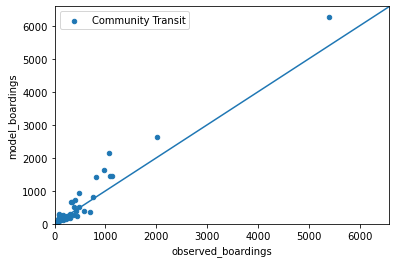

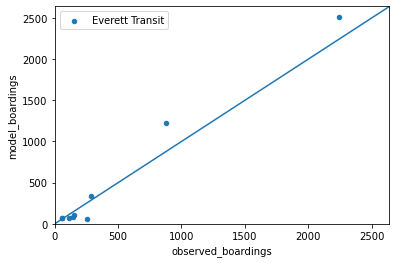

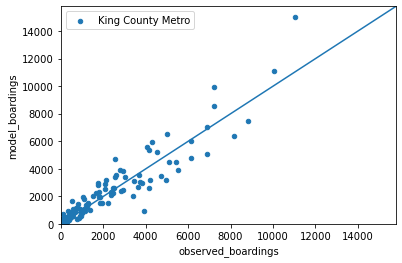

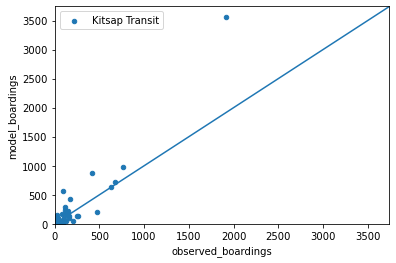

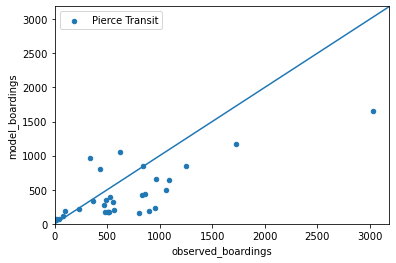

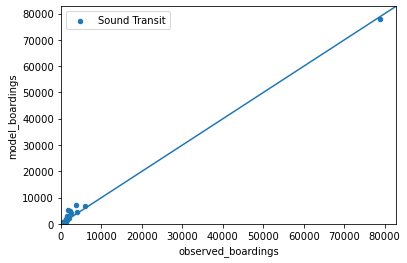

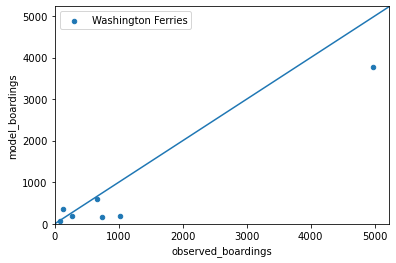

In [25]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [26]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

line_1_station_list = ['Northgate Station','Roosevelt Station','University District Station', 
                'Husky Stadium', 'Capitol Hill', 'Westlake', 'Symphony', 'Pioneer Square',
                "Int'l District",  'Stadium', 'SODO', 'Beacon Hill',
               'Mount Baker', 'Columbia City', 'Othello', 'Rainier Beach',
                "Tukwila Int'l Blvd", 'SeaTac/Airport', 'Angle Lake']
t_line_station_list = ['Tacoma Dome Station', 'S 25th St Station', 'Union Station',
       'Convention Center Station', 'Commerce Station']

In [27]:
line_1_df = df_table.loc[line_1_station_list]
line_1_df

observed_boardings  model_boardings      diff  \
station_name                                                                 
Northgate Station                     10,384.00         6,875.48 -3,508.52   
Roosevelt Station                      4,349.00         8,211.36  3,862.36   
University District Station            7,563.00         6,426.50 -1,136.50   
Husky Stadium                          6,134.00         3,521.70 -2,612.30   
Capitol Hill                           7,667.00         7,405.99   -261.01   
Westlake                               8,845.00         9,513.88    668.88   
Symphony                               4,324.00         5,781.74  1,457.74   
Pioneer Square                         2,400.00         5,285.32  2,885.32   
Int'l District                         4,399.00         1,842.69 -2,556.31   
Stadium                                1,731.00           354.38 -1,376.62   
SODO                                   1,669.00         2,312.08    643.08   
Beacon Hill                            2,147.00         1,344.96   -802.04   
Mount Baker                            1,861.00         1,691.20   -169.80   
Columbia City                          1,630.00         1,713.53     83.53   
Othello                                2,030.00         2,062.07     32.07   
Rainier Beach                          1,495.00         1,647.96    152.96   
Tukwila Int'l Blvd                     2,298.00         2,963.31    665.31   
SeaTac/Airport                         4,731.00         5,982.43  1,251.43   
Angle Lake                             3,865.00         2,980.43   -884.57   

                            percent_diff  
station_name                              
Northgate Station                -33.79%  
Roosevelt Station                 88.81%  
University District Station      -15.03%  
Husky Stadium                    -42.59%  
Capitol Hill                      -3.40%  
Westlake                           7.56%  
Symphony                          33.71%  
Pioneer Square                   120.22%  
Int'l District                   -58.11%  
Stadium                          -79.53%  
SODO                              38.53%  
Beacon Hill                      -37.36%  
Mount Baker                       -9.12%  
Columbia City                      5.12%  
Othello                            1.58%  
Rainier Beach                     10.23%  
Tukwila Int'l Blvd                28.95%  
SeaTac/Airport                    26.45%  
Angle Lake                       -22.89%

In [28]:
fig = px.line(line_1_df[['observed_boardings','model_boardings']])
fig.update_layout(height=500, width=900, font=dict(size=11),
                  yaxis_tickformat = '.00f')
fig.show()

In [29]:
t_line_df = df_table.loc[t_line_station_list]
t_line_df

observed_boardings  model_boardings    diff  \
station_name                                                             
Tacoma Dome Station                    494.00           318.05 -175.95   
S 25th St Station                      120.00           375.32  255.32   
Union Station                          420.00           185.73 -234.27   
Convention Center Station               91.00           512.85  421.85   
Commerce Station                       294.00           505.39  211.39   

                          percent_diff  
station_name                            
Tacoma Dome Station            -35.62%  
S 25th St Station              212.76%  
Union Station                  -55.78%  
Convention Center Station      463.57%  
Commerce Station                71.90%

In [30]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/Symphony'
df_combined.loc[['Symphony'],'station_group'] = 'Westlake/Symphony'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined.loc[['University District Station'],'station_group'] = 'U District/Husky Stadium'
df_combined.loc[['Husky Stadium'],'station_group'] = 'U District/Husky Stadium'

df_combined.loc[['Northgate Station'],'station_group'] = 'Northgate/Roosevelt'
df_combined.loc[['Roosevelt Station'],'station_group'] = 'Northgate/Roosevelt'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined = df_combined.loc[['Northgate/Roosevelt','U District/Husky Stadium','Capitol Hill','Westlake/Symphony',"Pioneer Square/Int'l District",
                             'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                             "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]
df_combined

observed_boardings  model_boardings      diff  \
station_group                                                                  
Northgate/Roosevelt                     14,733.00        15,086.83    353.83   
U District/Husky Stadium                13,697.00         9,948.21 -3,748.79   
Capitol Hill                             7,667.00         7,405.99   -261.01   
Westlake/Symphony                       13,169.00        15,295.62  2,126.62   
Pioneer Square/Int'l District            6,799.00         7,128.01    329.01   
Stadium/SODO                             3,400.00         2,666.46   -733.54   
Beacon Hill/Mount Baker                  4,008.00         3,036.16   -971.84   
Columbia City                            1,630.00         1,713.53     83.53   
Othello/Rainier Beach                    3,525.00         3,710.02    185.02   
Tukwila Int'l Blvd                       2,298.00         2,963.31    665.31   
SeaTac/Airport                           4,731.00         5,982.43  1,251.43   
Angle Lake                               3,865.00         2,980.43   -884.57   

                              percent_diff  
station_group                               
Northgate/Roosevelt                  2.40%  
U District/Husky Stadium           -27.37%  
Capitol Hill                        -3.40%  
Westlake/Symphony                   16.15%  
Pioneer Square/Int'l District        4.84%  
Stadium/SODO                       -21.57%  
Beacon Hill/Mount Baker            -24.25%  
Columbia City                        5.12%  
Othello/Rainier Beach                5.25%  
Tukwila Int'l Blvd                  28.95%  
SeaTac/Airport                      26.45%  
Angle Lake                         -22.89%

In [31]:

fig = px.line(df_combined[['observed_boardings','model_boardings']])
fig.update_layout(height=500, width=900, font=dict(size=11),
                  yaxis_tickformat = '.00f')
fig.show()

In [32]:
df_obs = pd.read_sql(
    "SELECT * FROM light_rail_station_boardings WHERE year IN (2023, 2024)",
    con=conn,
)
df_obs.rename(columns={"boardings": "observed_boardings"}, inplace=True)

# df_obs.groupby(['year','station_name']).sum()
df_obs = pd.pivot_table(df_obs, values='observed_boardings', columns='year', index='station_name', aggfunc=np.sum)
df_obs = df_obs.fillna(0)
df_obs

df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name', usecols=['station_name','model_boardings'])
df = df.merge(df_obs,  left_index=True, right_index=True, how='outer')
df = df[df.index != 'Total']
df = df[~df['model_boardings'].isnull()]
df = df.loc[line_1_station_list]

In [33]:
fig = px.line(df[[2023,2024,'model_boardings']])
fig.update_layout(height=500, width=900, font=dict(size=11),
                  yaxis_tickformat = '.00f')
fig.show()

## light rail stop transfers

In [34]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df.loc[line_1_station_list]

modeled_transfer_rate  observed_transfer_rate  \
station_name                                                                 
Northgate Station                             0.68                  -99.00   
Roosevelt Station                             0.42                  -99.00   
University District Station                   0.22                  -99.00   
Husky Stadium                                 0.82                  -99.00   
Capitol Hill                                  0.06                  -99.00   
Westlake                                      0.13                    0.36   
Symphony                                      0.32                    0.20   
Pioneer Square                                0.39                    0.16   
Int'l District                                0.53                    0.45   
Stadium                                       0.36                    0.12   
SODO                                          0.65                    0.31   
Beacon Hill                                   0.32                    0.35   
Mount Baker                                   0.42                    0.32   
Columbia City                                 0.01                    0.12   
Othello                                       0.04                    0.12   
Rainier Beach                                 0.30                    0.36   
Tukwila Int'l Blvd                            0.44                    0.26   
SeaTac/Airport                                0.13                    0.26   
Angle Lake                                    0.24                  -99.00   

                             diff percent_diff  
station_name                                    
Northgate Station           99.68     -100.69%  
Roosevelt Station           99.42     -100.42%  
University District Station 99.22     -100.22%  
Husky Stadium               99.82     -100.83%  
Capitol Hill                99.06     -100.06%  
Westlake                    -0.23      -63.87%  
Symphony                     0.12       58.16%  
Pioneer Square               0.23      146.44%  
Int'l District               0.08       17.32%  
Stadium                      0.25      206.50%  
SODO                         0.34      107.42%  
Beacon Hill                 -0.04      -10.46%  
Mount Baker                  0.10       30.01%  
Columbia City               -0.11      -90.69%  
Othello                     -0.08      -63.48%  
Rainier Beach               -0.06      -15.85%  
Tukwila Int'l Blvd           0.17       66.13%  
SeaTac/Airport              -0.14      -51.58%  
Angle Lake                  99.24     -100.25%

## Park and Ride

In [35]:
df_trip = pd.read_csv(r'..\..\..\..\outputs\daysim\_trip.tsv', sep='\t')
pnr_boardings = df_trip[(df_trip['otaz'].isin(range(3750,4001))) & (df_trip['mode']==6)]
pnr_boardings = pnr_boardings.groupby('otaz').count()[['trexpfac']].reset_index()

In [36]:
stations = [
    {"id": 3751, "name": "Tukwila Station (CR)"},
    {"id": 3752, "name": "Tacoma Dome Station"},
    {"id": 3753, "name": "South Tacoma (CR)"},
    {"id": 3754, "name": "Everett Station (CR)"},
    {"id": 3755, "name": "Sumner Station (CR)"},
    {"id": 3756, "name": "Mukilteo Station"},
    {"id": 3757, "name": "Kent Station (CR)"},
    {"id": 3758, "name": "Auburn Station (CR)"},
    {"id": 3759, "name": "Lakewood (CR)"},
    {"id": 3760, "name": "Gateway P&R"},
    {"id": 3761, "name": "Puyallup Station (SB)"},
    {"id": 3762, "name": "Twin Lakes P&R"},
    {"id": 3763, "name": "Crossroads Neighborhood Church"},
    {"id": 3764, "name": "Overlake Transit Center"},
    {"id": 3765, "name": "Redondo Heights P&R"},
    {"id": 3766, "name": "North Gig Harbor/Kimball Drive"},
    {"id": 3767, "name": "Duvall P&R"},
    {"id": 3768, "name": "Roy 'Y' P&R"},
    {"id": 3769, "name": "South Hill (Elim Evangelical)"},
    {"id": 3770, "name": "Parkland Transit Center"},
    {"id": 3771, "name": "SR-512/I-5 (Lakewood)"},
    {"id": 3772, "name": "Center Street P&R"},
    {"id": 3773, "name": "Tacoma Mall Transit Center"},
    {"id": 3774, "name": "South Tacoma West"},
    {"id": 3775, "name": "South Tacoma East - 2"},
    {"id": 3776, "name": "Narrows P&R"},
    {"id": 3777, "name": "North Purdy/Purdy Crescent"},
    {"id": 3778, "name": "Point Defiance Ferry"},
    {"id": 3779, "name": "South Federal P&R"},
    {"id": 3780, "name": "Sultan P&R"},
    {"id": 3781, "name": "Federal Way P&R (320th)"},
    {"id": 3782, "name": "Auburn P&R"},
    {"id": 3783, "name": "Star Lake P&R"},
    {"id": 3784, "name": "Holy Spirit Lutheran Church"},
    {"id": 3785, "name": "Kent/Des Moines P&R"},
    {"id": 3786, "name": "Kent/James St. P&R"},
    {"id": 3787, "name": "Burien Transit Center"},
    {"id": 3788, "name": "Tukwila"},
    {"id": 3789, "name": "Maple Valley P&R"},
    {"id": 3790, "name": "South Renton P&R"},
    {"id": 3791, "name": "Renton Highlands P&R (St. Matts)"},
    {"id": 3792, "name": "Issaquah Transit Center"},
    {"id": 3793, "name": "Mercer Island P&R"},
    {"id": 3794, "name": "Mercer Island Presbyterian"},
    {"id": 3795, "name": "Newport Hills P&R"},
    {"id": 3796, "name": "Newport Hills Community Church"},
    {"id": 3797, "name": "Newport Covenant Church"},
    {"id": 3798, "name": "South Bellevue P&R"},
    {"id": 3799, "name": "Wilburton"},
    {"id": 3800, "name": "Eastgate P&R"},
    {"id": 3801, "name": "North Bend P&R"},
    {"id": 3802, "name": "Evergreen Point P&R"},
    {"id": 3803, "name": "Grace Lutheran Church"},
    {"id": 3804, "name": "South Kirkland P&R"},
    {"id": 3805, "name": "Overlake P&R"},
    {"id": 3806, "name": "Houghton P&R"},
    {"id": 3807, "name": "Bethel Lutheran"},
    {"id": 3808, "name": "Redmond P&R"},
    {"id": 3809, "name": "Saint Thomas Episcopal"},
    {"id": 3810, "name": "Valley Center"},
    {"id": 3811, "name": "Bear Creek P&R"},
    {"id": 3812, "name": "Kingsgate P&R"},
    {"id": 3813, "name": "Brickyard P&R"},
    {"id": 3814, "name": "Northshore P&R"},
    {"id": 3815, "name": "Kenmore P&R"},
    {"id": 3816, "name": "Bethany Bible Church"},
    {"id": 3817, "name": "Bothell P&R"},
    {"id": 3818, "name": "Woodinville P&R"},
    {"id": 3819, "name": "Olson & Meyers"},
    {"id": 3820, "name": "Spokane Street P&R"},
    {"id": 3821, "name": "Greenlake P&R"},
    {"id": 3822, "name": "Northgate TC"},
    {"id": 3823, "name": "North Jackson Park"},
    {"id": 3824, "name": "Shoreline"},
    {"id": 3825, "name": "112th St. & I-5"},
    {"id": 3826, "name": "Ober Park"},
    {"id": 3827, "name": "Vashon Heights"},
    {"id": 3828, "name": "Mountlake Terrace P&R"},
    {"id": 3829, "name": "Bethesda Lutheran"},
    {"id": 3830, "name": "Edmonds Station"},
    {"id": 3831, "name": "Edmonds P&R"},
    {"id": 3832, "name": "Lynnwood P&R"},
    {"id": 3833, "name": "Swamp Creek P&R"},
    {"id": 3834, "name": "Mariner P&R"},
    {"id": 3835, "name": "Snohomish"},
    {"id": 3836, "name": "Marysville - Ash Ave"},
    {"id": 3837, "name": "116th & I-5 - Marysville"},
    {"id": 3838, "name": "SR-531 - Marysville"},
    {"id": 3839, "name": "Arlington P&R"},
    {"id": 3840, "name": "Stanwood"},
    {"id": 3841, "name": "Monroe"},
    {"id": 3842, "name": "Federal Way"},
    {"id": 3843, "name": "Port Orchard Armory"},
    {"id": 3844, "name": "Southworth Ferry P&R"},
    {"id": 3845, "name": "McWilliams P&R"},
    {"id": 3846, "name": "Bethany Lutheran Church"},
    {"id": 3847, "name": "Gateway Fellowship"},
    {"id": 3848, "name": "Agate Pass P&R/Clearwater"},
    {"id": 3849, "name": "Kingston Ferry P&R"},
    {"id": 3850, "name": "Suquamish United Church of Christ"},
    {"id": 3851, "name": "Bainbridge Island Ferry"},
    {"id": 3852, "name": "Puyallup Station (NB)"},
    {"id": 3853, "name": "72nd Street Transit Center"},
    {"id": 3855, "name": "DuPont"},
    {"id": 3856, "name": "Aurora Village TC"},
    {"id": 3857, "name": "Aurora Nazarene"},
    {"id": 3858, "name": "Saint Margaret's Episcopal"},
    {"id": 3861, "name": "Lake Meridian P&R"},
    {"id": 3862, "name": "Smokey Pt. Church"},
    {"id": 3863, "name": "Eastmont P&R"},
    {"id": 3864, "name": "McCollum Park P&R"},
    {"id": 3865, "name": "Canyon Park P&R"},
    {"id": 3866, "name": "Korean Presby. P&R"},
    {"id": 3867, "name": "Georges Kountry Korner"},
    {"id": 3868, "name": "Poulsbo Church of the Nazarene"},
    {"id": 3870, "name": "Harper Evangelical Free Church"},
    {"id": 3871, "name": "Mullenix Road"},
    {"id": 3873, "name": "TCC P&R"},
    {"id": 3874, "name": "Ash Way P&R"},
    {"id": 3875, "name": "Bonney Lake P&R"},
    {"id": 3876, "name": "Tukwila Int. Station"},
    {"id": 3877, "name": "South Hill P&R"},
    {"id": 3878, "name": "South Tacoma East - 1"},
    {"id": 3879, "name": "Issaquah Highlands"},
    {"id": 3880, "name": "Lake Stevens TC"},
    {"id": 3881, "name": "Liberty Bay Presbyterian"},
    {"id": 3882, "name": "NK Baptist"},
    {"id": 3883, "name": "Preston P&R"},
    {"id": 3884, "name": "Bayside Community Church"},
    {"id": 3885, "name": "Ollala Valley Fire Station"},
    {"id": 3886, "name": "Bremerton Ferry"},
    {"id": 3888, "name": "Puyallup Fair's Red Lot"},
    {"id": 3889, "name": "Marysville - Cedar & Grove"},
    {"id": 3890, "name": "Stanwood II"},
    {"id": 3891, "name": "Marysville I P&R"},
    {"id": 3892, "name": "Martha Lake Covenant Church"},
    {"id": 3893, "name": "South Sammammish P&R"},
    {"id": 3894, "name": "Renton City Municipal Garage"},
    {"id": 3895, "name": "Tibbetts Lot"},
    {"id": 3896, "name": "Renton Transit Center"},
    {"id": 3897, "name": "Calvary Christian Assembly"},
    {"id": 3898, "name": "Maple Valley Town Square"},
    {"id": 3899, "name": "All Saints Lutheran Church"},
    {"id": 3900, "name": "City View Church"},
    {"id": 3901, "name": "Northwest University 6710 Bldg."},
    {"id": 3902, "name": "Sammamish Lutheran P&R"},
    {"id": 3903, "name": "Redmond Ridge P&R"},
    {"id": 3904, "name": "Kennydale United Methodist Church"},
    {"id": 3905, "name": "Nativity Lutheran Church"},
    {"id": 3906, "name": "South Jackson P&R"},
    {"id": 3907, "name": "South SeaTac (LR)"},
    {"id": 3908, "name": "Everett Station"},
    {"id": 3909, "name": "Bremerton (SR-303/Riddell Road)"},
    {"id": 3910, "name": "Silverdale"},
    {"id": 3911, "name": "Tukwila Station (CR)"},
    {"id": 3913, "name": "Sumner Station Garage"},
    {"id": 3914, "name": "Tacoma Dome"},
    {"id": 3915, "name": "Bothell (SR-527/185th Street)"},
    {"id": 3916, "name": "SR-3/SR-303"},
    {"id": 3917, "name": "SR-16/SR-160"},
    {"id": 3918, "name": "I-5 & 175th"}
]

In [37]:
pnr_capacity = pd.read_csv(r'..\..\..\..\inputs\scenario\networks\p_r_nodes.csv')
df = pnr_capacity.merge(pnr_boardings, left_on='ZoneID', right_on='otaz')
df.rename(columns={'ZoneID': 'taz', 'trexpfac': 'Model Boardings'}, inplace=True)
df['Boardings/Capacity'] = df['Model Boardings']/df['Capacity']
# df.head()

In [38]:
df_station_names = pd.DataFrame(stations)
df = df.merge(df_station_names, how='left', left_on='taz', right_on='id')

In [39]:
df['color'] = np.where(df['Boardings/Capacity'] > 1, 'Boardings/Capacity > 1', 'Boardings/Capacity <= 1')

fig = px.scatter(df, y='Model Boardings', x='Capacity', title='Model Boardings vs Capacity',
                 hover_data={'name': True, 'Model Boardings': True, 'Capacity': True, 'Boardings/Capacity': ':.2f'},
                 color='color')
fig.update_layout(height=600, width=800)
fig.show()

In [40]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.XCoord, df.YCoord), crs='EPSG:2285')
gdf.to_crs('EPSG:4326', inplace=True)

fig = px.scatter_mapbox(gdf, lat=gdf.geometry.y, lon=gdf.geometry.x, color='Boardings/Capacity', 
                        size='Boardings/Capacity', hover_data=['name','taz','Model Boardings', 'Capacity'], 
                        title='Park and Ride Usage vs Capacity', zoom=8)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

# Transit Submodes by Purpose
Model Outputs Only (insufficient samples available from survey)

In [41]:
import h5py
myh5 = h5py.File(r'..\..\..\..\inputs\scenario\landuse\hh_and_persons.h5', 'r')
person = pd.read_csv(r'..\..\..\..\outputs\daysim\_person.tsv', sep='\t')

In [42]:
# Create a DataFrame from the h5 file
df_person = pd.DataFrame()
for col in ['hhno','pno','prace']:
    df_person[col] = myh5['Person'][col][:]

df_trip = df_trip.merge(df_person[['hhno','pno','prace']], on=['hhno','pno'], how='left')

In [43]:
# Create group of work, school, and all other purposes
df_trip['Purpose Type'] = 'Other'
df_trip.loc[df_trip['dpurp']==0, 'Purpose Type'] = 'Home'
df_trip.loc[df_trip['dpurp']==1, 'Purpose Type'] = 'Work'
df_trip.loc[df_trip['dpurp']==2, 'Purpose Type'] = 'School'

# Rename path types
df_trip.loc[df_trip['pathtype']==1, 'Path Type'] = 'Drive'
df_trip.loc[df_trip['pathtype']==3, 'Path Type'] = 'Bus'
df_trip.loc[df_trip['pathtype']==4, 'Path Type'] = 'Light Rail'
df_trip.loc[df_trip['pathtype']==5, 'Path Type'] = 'Ferry 1'
df_trip.loc[df_trip['pathtype']==6, 'Path Type'] = 'Commuter Rail'
df_trip.loc[df_trip['pathtype']==7, 'Path Type'] = 'Ferry 2'

df = pd.pivot_table(df_trip[(df_trip['dpurp']!=0) & (df_trip['pathtype']!=0)], values='trexpfac', index='Path Type', columns='Purpose Type', aggfunc=np.sum)

df['Total'] = df.sum(axis=1)
for row in df.index:
    for col in ['Work','School','Other']:
        df.loc[row, col + ' %'] = df.loc[row, col] / df.loc[row, 'Total']

df[['Work %','School %','Other %']] = df[['Work %','School %','Other %']].applymap("{:,.1%}".format)
df[['Work %','School %','Other %']]

Purpose Type  Work % School % Other %
Path Type                            
Bus            14.8%    10.8%   74.4%
Commuter Rail  50.6%     2.0%   47.4%
Drive          19.6%     5.5%   74.8%
Ferry 1        37.0%    20.6%   42.4%
Ferry 2        62.9%     2.0%   35.1%
Light Rail     32.6%     6.2%   61.2%

#### Transit Submodes by Person Race

In [44]:

race_dict = {
    '1': 'White alone',
    '2': 'Black or African American alone',
    '3': 'American Indian alone',
    '4': 'Alaska Native alone',
    '5': 'American Indian and Alaska Native tribes specified',
    '6': 'Asian alone',
    '7': 'Native Hawaiian and Other Pacific Islander alone',
    '8': 'Some Other Race alone',
    '9': 'Two or More Races'
}


df_trip['Race'] = df_trip['prace'].astype('int').astype('str').map(race_dict)

In [45]:
# Submode Ridership by race
df = pd.pivot_table(df_trip[(df_trip['pathtype']!=0)], values='trexpfac', index='Path Type', columns='Race', aggfunc=np.sum)
race_cols = ['White alone','Black or African American alone','American Indian alone',
             'Alaska Native alone','American Indian and Alaska Native tribes specified','Asian alone',
             'Native Hawaiian and Other Pacific Islander alone','Some Other Race alone','Two or More Races']
# Calculate shares of total by Race for each Path Type
df['Total'] = df.sum(axis=1)
for row in df.index:
    for col in race_cols:
        df.loc[row, col] = df.loc[row, col] / df.loc[row, 'Total']
df[race_cols] = df[race_cols].applymap("{:,.1%}".format)

In [46]:
df[race_cols]

Race          White alone Black or African American alone  \
Path Type                                                   
Bus                 59.4%                            7.5%   
Commuter Rail       63.9%                            7.5%   
Drive               64.7%                            5.5%   
Ferry 1             77.6%                            2.9%   
Ferry 2             81.2%                            2.7%   
Light Rail          57.9%                            8.8%   

Race          American Indian alone Alaska Native alone  \
Path Type                                                 
Bus                            0.6%                0.1%   
Commuter Rail                  0.9%                0.1%   
Drive                          0.6%                0.1%   
Ferry 1                        0.5%                nan%   
Ferry 2                        0.9%                0.1%   
Light Rail                     0.5%                0.1%   

Race          American Indian and Alaska Native tribes specified Asian alone  \
Path Type                                                                      
Bus                                                         0.1%       18.9%   
Commuter Rail                                               0.0%       11.0%   
Drive                                                       0.1%       14.8%   
Ferry 1                                                     0.2%        6.1%   
Ferry 2                                                     0.1%        4.1%   
Light Rail                                                  0.1%       20.6%   

Race          Native Hawaiian and Other Pacific Islander alone  \
Path Type                                                        
Bus                                                       0.6%   
Commuter Rail                                             1.7%   
Drive                                                     1.0%   
Ferry 1                                                   1.5%   
Ferry 2                                                   0.9%   
Light Rail                                                0.5%   

Race          Some Other Race alone Two or More Races  
Path Type                                              
Bus                            3.9%              9.0%  
Commuter Rail                  5.6%              9.3%  
Drive                          4.3%              8.9%  
Ferry 1                        2.7%              8.5%  
Ferry 2                        2.7%              7.3%  
Light Rail                     3.8%              7.8%